# Пример анализа данных TS

HAR (Human Activity Recognition) dataset — это набор данных для распознавания активности человека на основе данных с датчиков. Обычно такие датасеты содержат информацию, полученную с акселерометров и гироскопов, установленных на теле человека (например, смартфон в кармане или носимые устройства).

Загрузим данный датасет с Kaggle

In [80]:
import kagglehub
erenaktas_human_activity_recognition_path = kagglehub.dataset_download('erenaktas/human-activity-recognition')
datadir = erenaktas_human_activity_recognition_path + "/UCI_HAR_Dataset"

# EDA & Data Visualisation

EDA (Exploratory Data Analysis — разведочный анализ данных) — это начальный этап анализа данных, в котором исследуется их структура, выявляются закономерности, выбросы и аномалии

In [81]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [82]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("seaborn-v0_8-whitegrid") # https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
sns.set_style("white") # https://seaborn.pydata.org/generated/seaborn.set_style.html
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import matplotlib as mpl

import os
for dirname, _, filenames in os.walk(datadir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/lxuser/.cache/kagglehub/datasets/erenaktas/human-activity-recognition/versions/1/UCI_HAR_Dataset/features_info.txt
/home/lxuser/.cache/kagglehub/datasets/erenaktas/human-activity-recognition/versions/1/UCI_HAR_Dataset/activity_labels.txt
/home/lxuser/.cache/kagglehub/datasets/erenaktas/human-activity-recognition/versions/1/UCI_HAR_Dataset/features.txt
/home/lxuser/.cache/kagglehub/datasets/erenaktas/human-activity-recognition/versions/1/UCI_HAR_Dataset/README.txt
/home/lxuser/.cache/kagglehub/datasets/erenaktas/human-activity-recognition/versions/1/UCI_HAR_Dataset/test/y_test.txt
/home/lxuser/.cache/kagglehub/datasets/erenaktas/human-activity-recognition/versions/1/UCI_HAR_Dataset/test/subject_test.txt
/home/lxuser/.cache/kagglehub/datasets/erenaktas/human-activity-recognition/versions/1/UCI_HAR_Dataset/test/X_test.txt
/home/lxuser/.cache/kagglehub/datasets/erenaktas/human-activity-recognition/versions/1/UCI_HAR_Dataset/test/Inertial Signals/total_acc_y_test.txt
/home/lxuser/.cac

## Data Pipeline
Functions to load the dataset

In [83]:
# load a single file as a numpy array
def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values

# load a list of files into a 3D array of [observations, timesteps, features(x,y,z)]
def load_group(files, prefix=''):
    loaded = list()
    for f in files:
        data = load_file(prefix + f)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + '/' + group + '/Inertial Signals/'
    # load all 9 files as a single array
    files = list()
    # body acceleration
    files += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    files += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # total acceleration
    files += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # load input data
    X = load_group(files, filepath)
    # load class output
    y = load_file(prefix + '/' + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    # load all train
    X_train, y_train = load_dataset_group('train', prefix)
    # load all test
    X_test, y_test = load_dataset_group('test', prefix)

    """
    # zero-offset class values
    y_train = y_train - 1
    y_test = y_test - 1
    # one hot encode y
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    """

    print(f"""Dataset loaded.
Training Set:
X_train {X_train.shape} y_train {y_train.shape}
Test Set:
X_test {X_test.shape} y_test {y_test.shape}""")
    return X_train, y_train, X_test, y_test

In [84]:
X_train, y_train, X_test, y_test = load_dataset(prefix=datadir)

Dataset loaded.
Training Set:
X_train (7352, 128, 9) y_train (7352, 1)
Test Set:
X_test (2947, 128, 9) y_test (2947, 1)


In [85]:
X_train.shape

(7352, 128, 9)

In [86]:
X_train[:][:][0][0]

array([ 1.808515e-04,  1.076681e-02,  5.556068e-02,  3.019122e-02,
        6.601362e-02,  2.285864e-02,  1.012817e+00, -1.232167e-01,
        1.029341e-01])

In [87]:
X_train[:][:][0][1]

array([ 0.01013856,  0.00657948,  0.05512483,  0.04371071,  0.04269897,
        0.01031572,  1.022833  , -0.1268756 ,  0.1056872 ])

In [88]:
activity = {
        1: 'Walking',
        2: 'Walking Upstairs',
        3: 'Walking Downstairs',
        4: 'Sitting',
        5: 'Standing',
        6: 'Laying'}
def activities(obs):
    return activity[int(y_train[obs])]

In [89]:
def features(feature):
    f={"Body acceleration": 0, "Gyro": 1, "Total acceleration": 2}
    return f[feature]

In [90]:
# Example for each activity
sample=[777, 666, 818, 0, 6666, 66]
[activity[int(y_train[i])] for i in sample]

['Walking',
 'Walking Upstairs',
 'Walking Downstairs',
 'Standing',
 'Sitting',
 'Laying']

## Data Visualisation
### Feature Signals (xyz)

In [91]:
# Grab values for graphs
def get_values(y_values, T, N, f_s, sample_rate):
    y_values = y_values
    x_values = [sample_rate * kk for kk in range(0,len(y_values))]
    return x_values, y_values

In [92]:
# Display x,y,z as separate lines for each feature
def signal_viz(obs):
    N = 128 # number of timesteps
    f_s = 50 # overlapped percentage
    t_n = 2.56 # time
    T = t_n / N
    sample_rate = 1 / f_s

    labels = ['x-component', 'y-component', 'z-component']
    colors = ['r', 'g', 'b']
    suptitle = "Different signals for the activity: {}"
    graph_name="graph/Signals {}.png"
    xlabel = 'Time [sec]'
    ylabel = 'Amplitude'
    axtitles = ['Body acceleration', 'Gyro', 'Total acceleration']
    activity_name = activities(obs)

    sns.set(style="white", font_scale = 1.7)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,8))


    for comp_no in range(0,9):
            col_no = comp_no // 3
            plot_no = comp_no % 3
            color = colors[plot_no]
            label = labels[plot_no]

            axtitle  = axtitles[col_no]

            ax = axes[col_no]
            ax.set_title(axtitle)
            ax.set_xlabel(xlabel)
            if col_no == 0:
                ax.set_ylabel(ylabel, fontsize=16)

            signal_component = X_train[obs][:, comp_no]
            x_values, y_values = get_values(signal_component, T, N, f_s, sample_rate)
            ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
            if col_no == 2:
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    fig.suptitle(suptitle.format(activity_name))
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, hspace=0.6)
    plt.show()

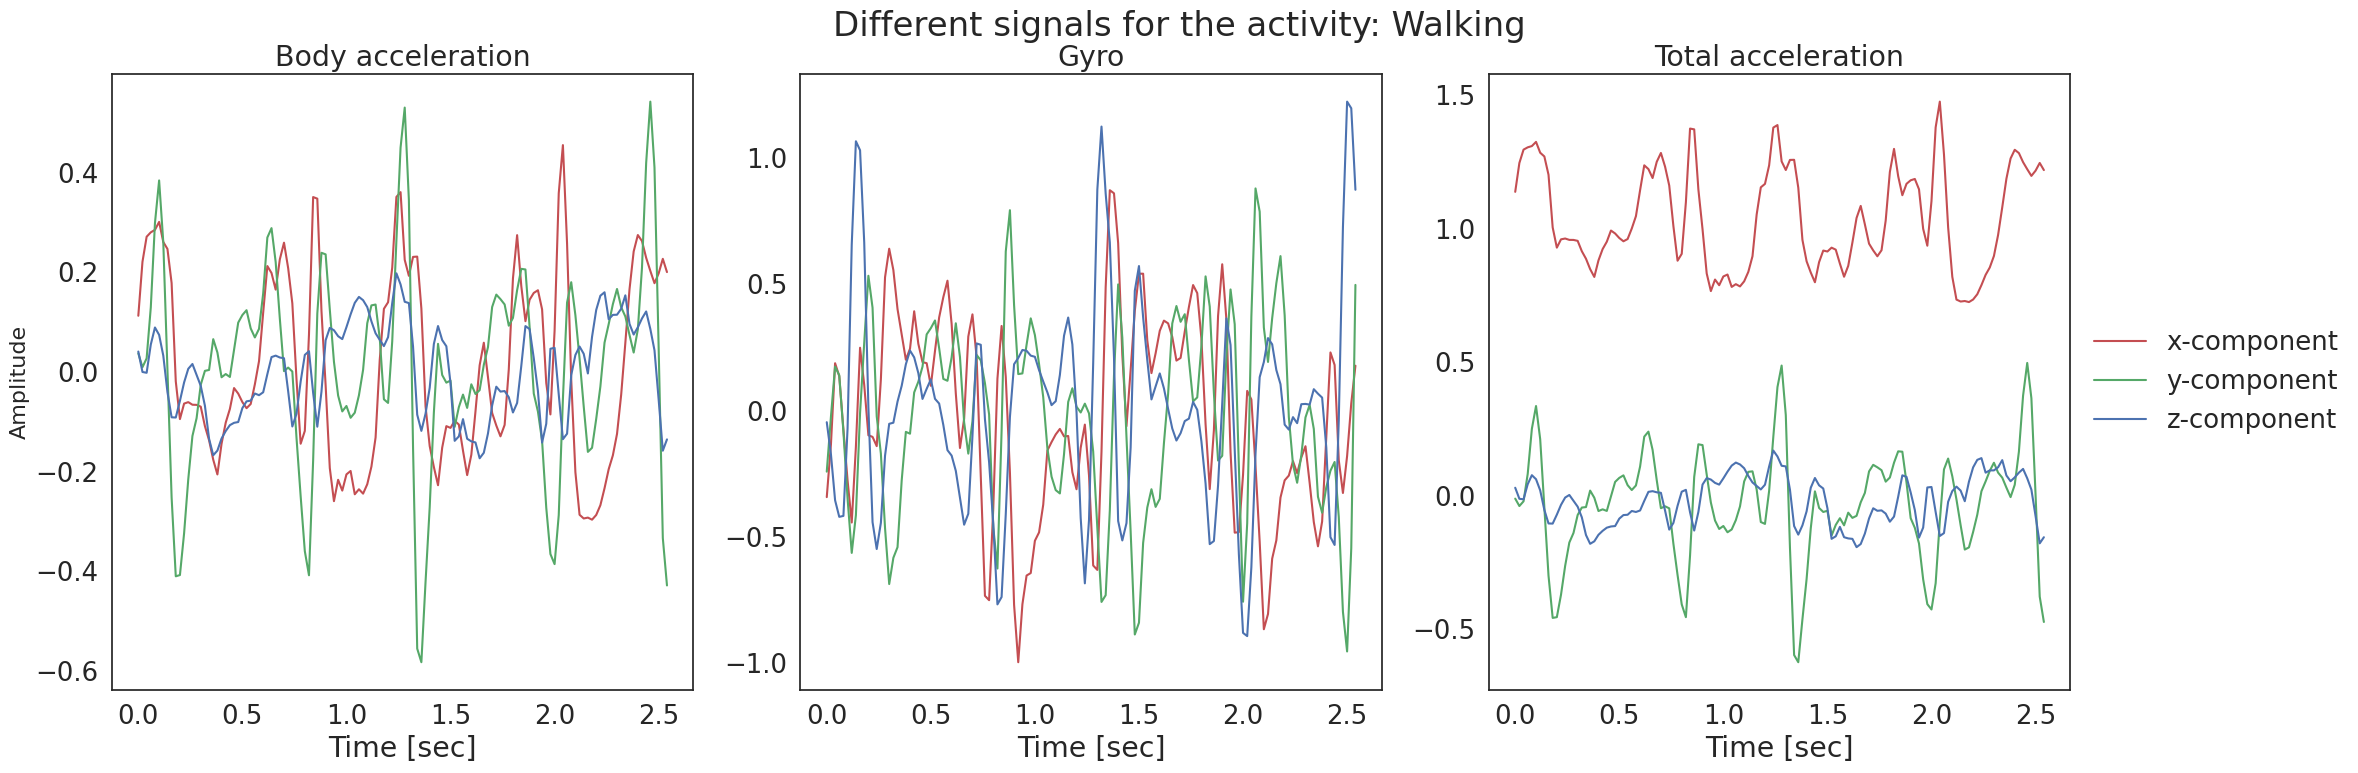

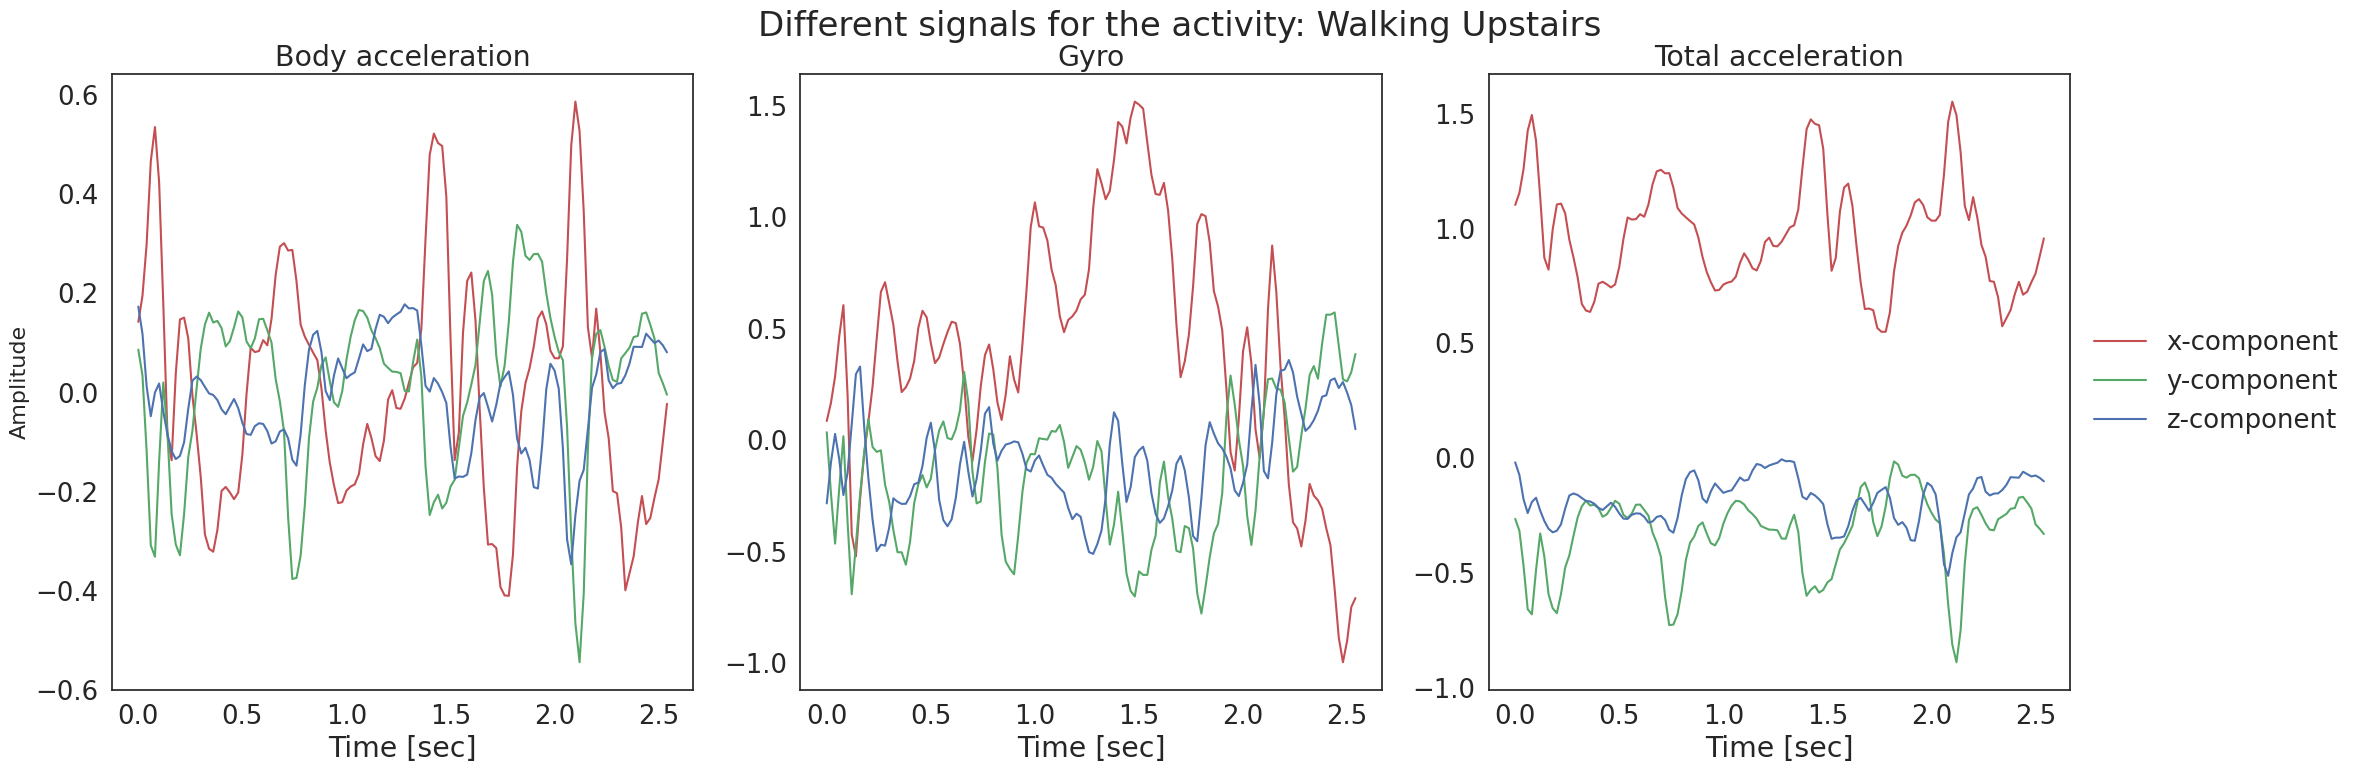

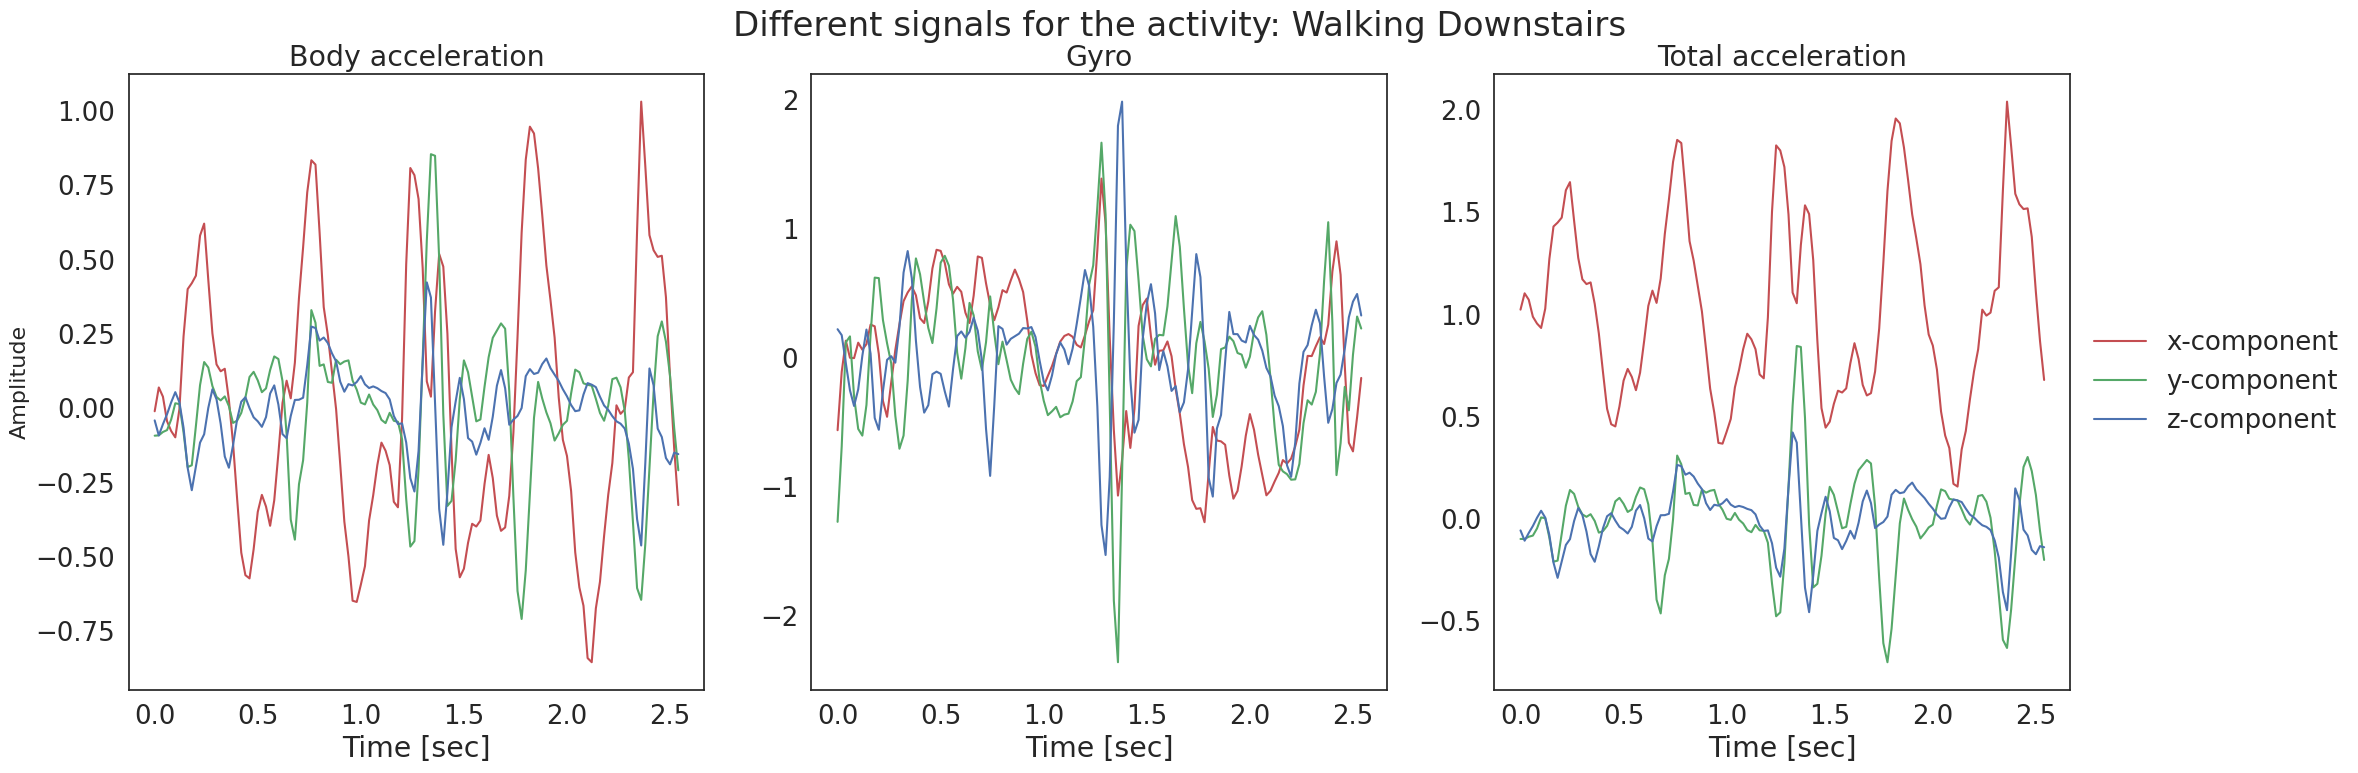

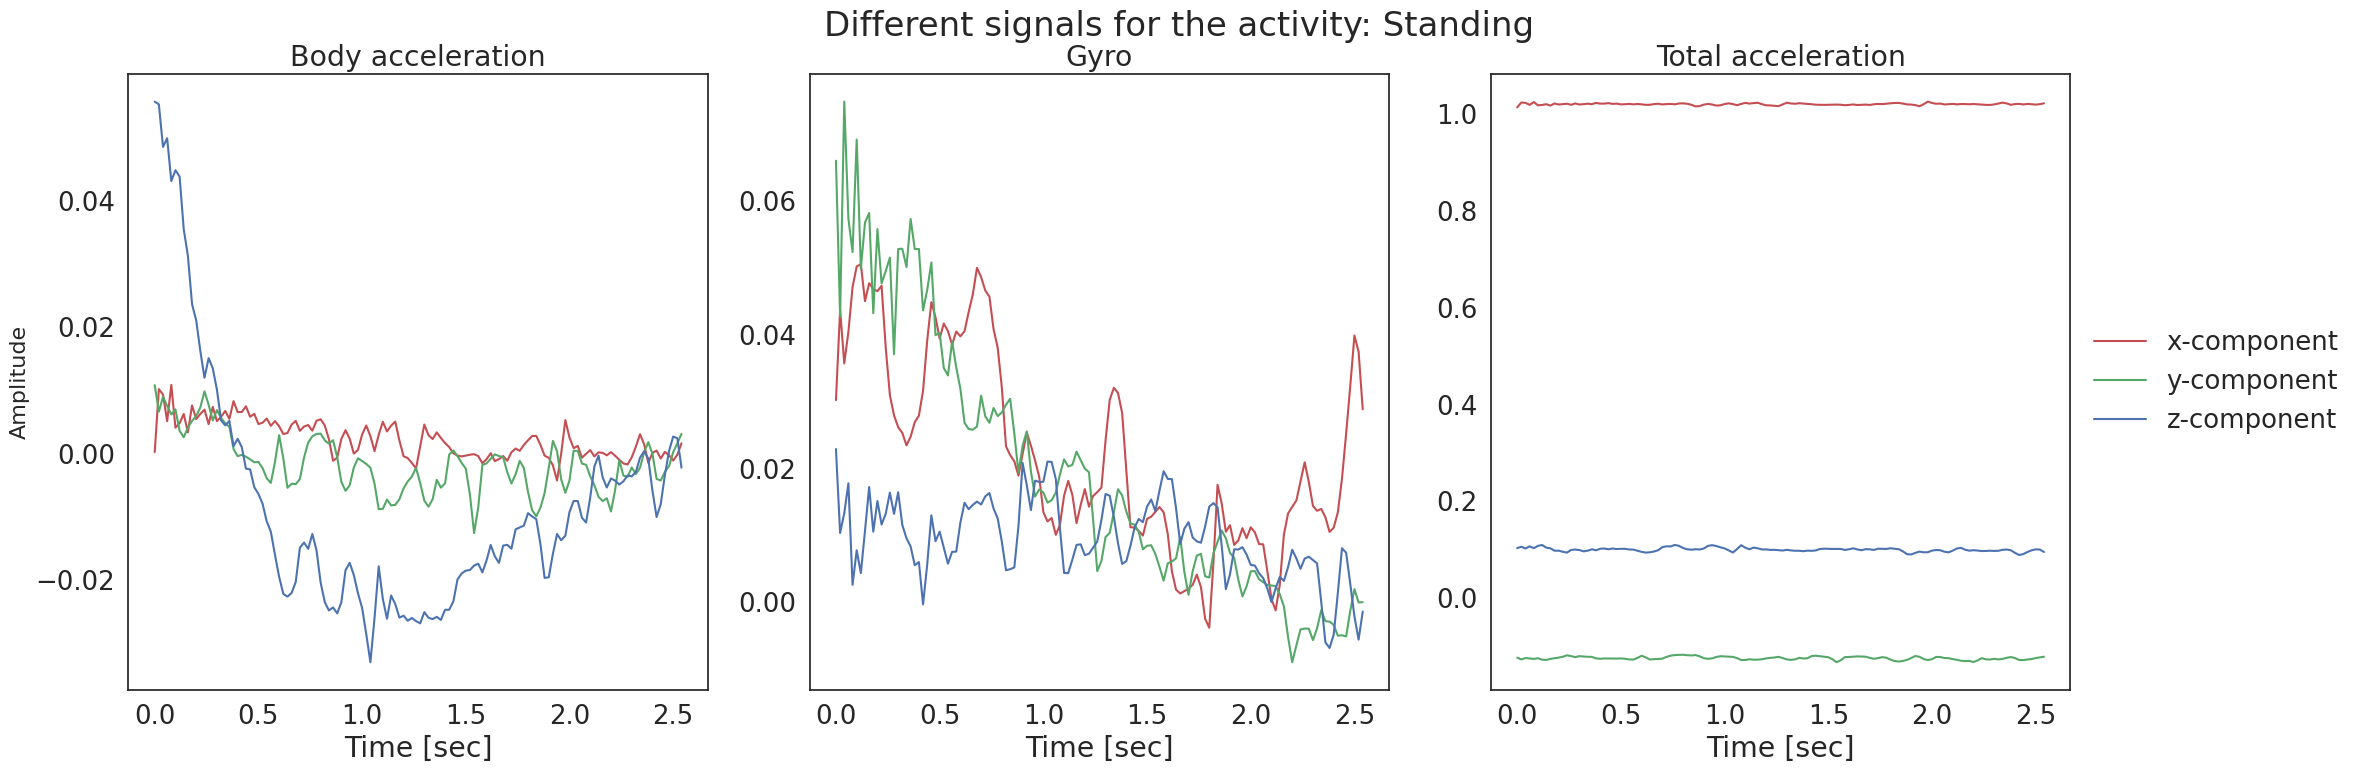

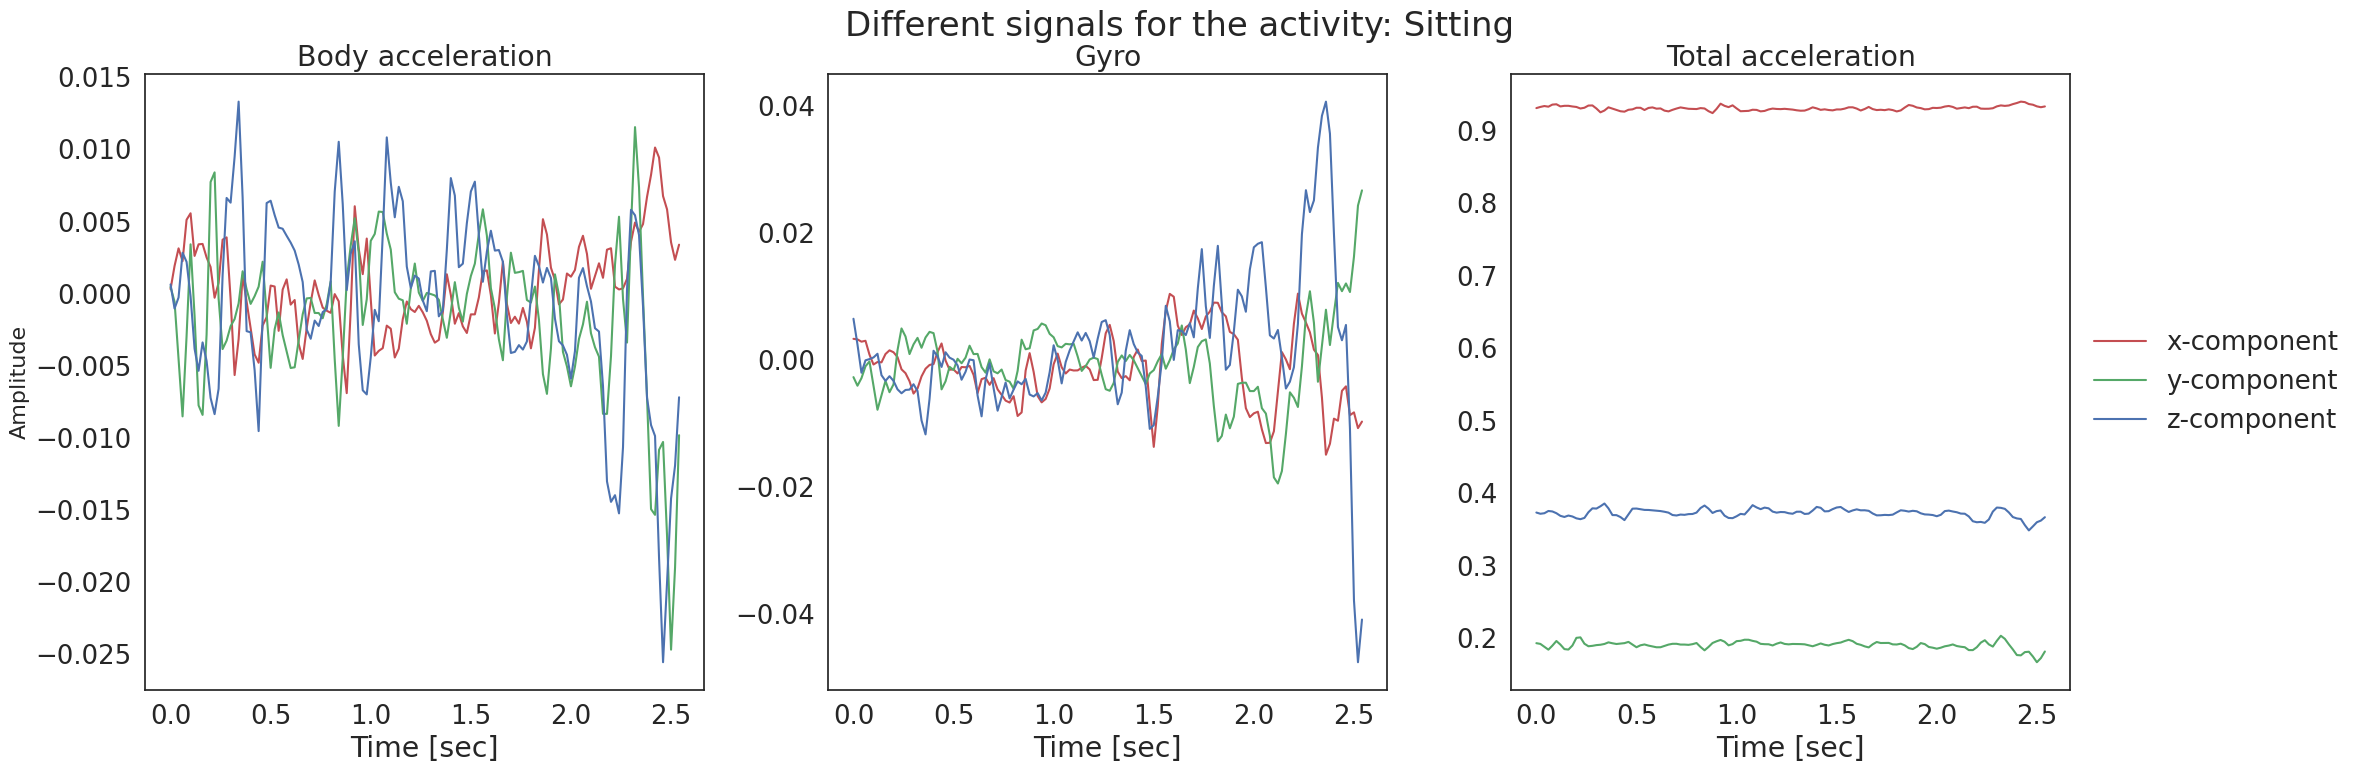

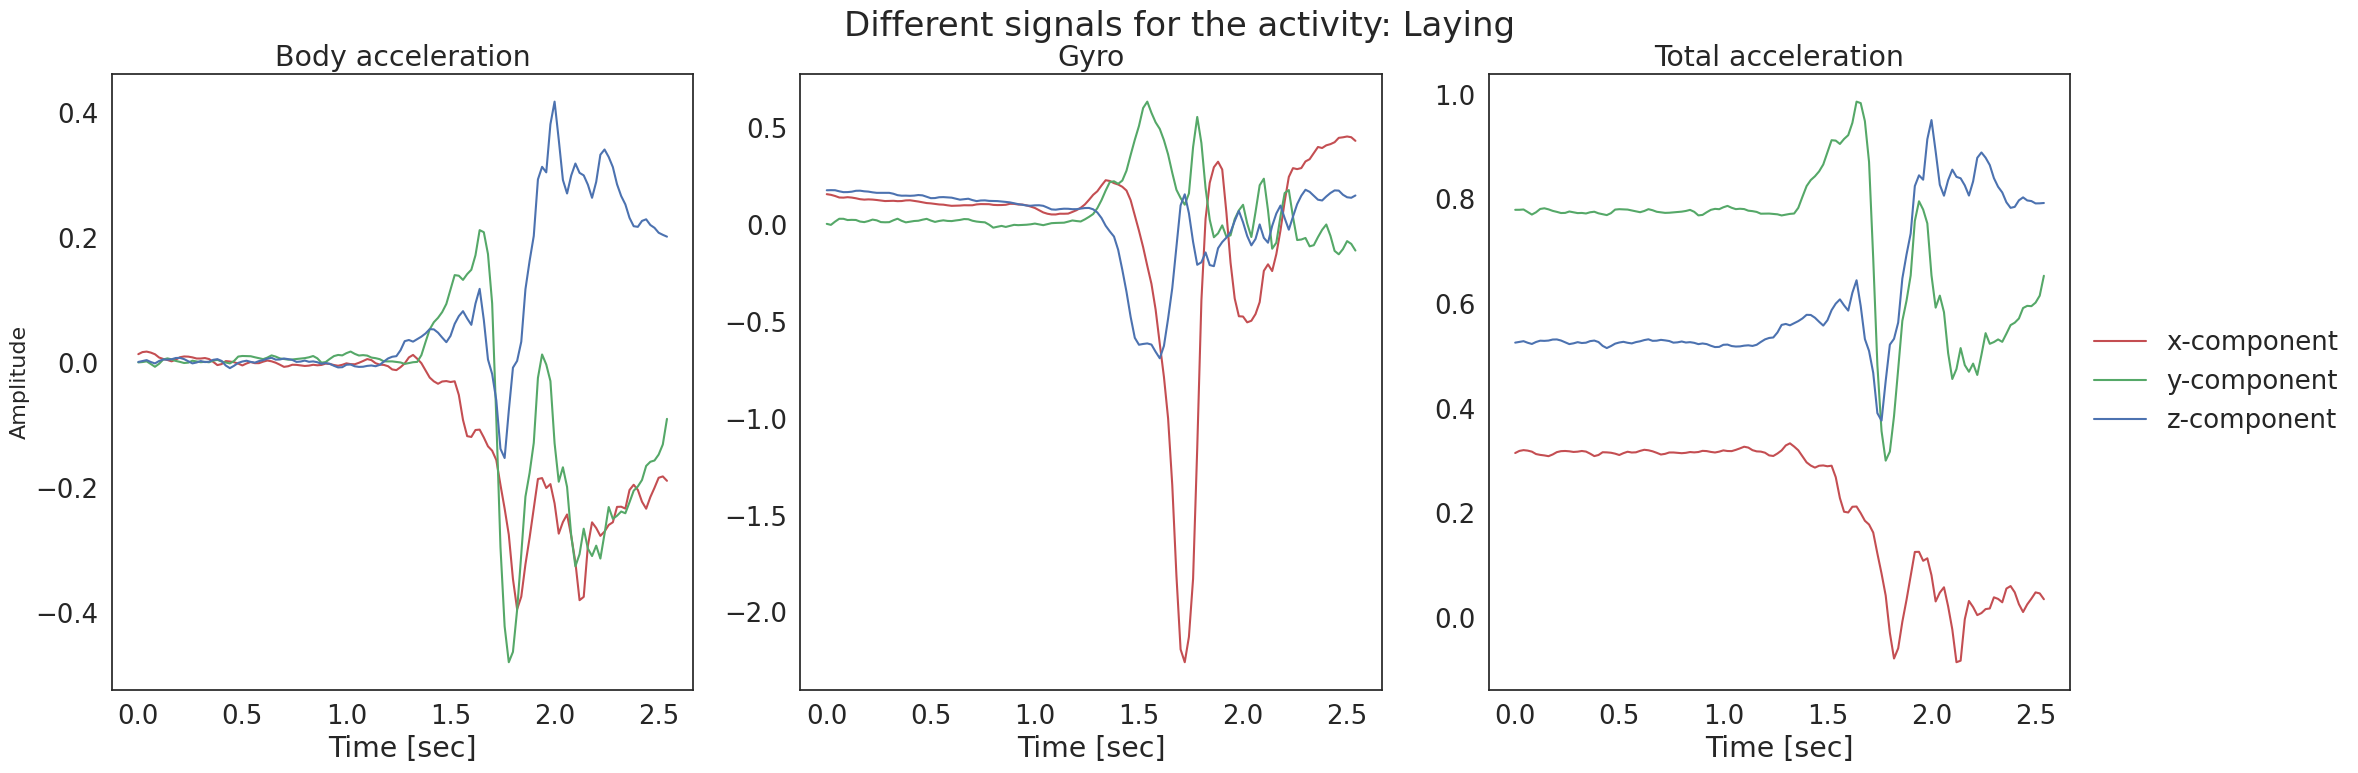

In [93]:
for i in sample:
    signal_viz(i)

Interesting visualisation, but difficult to interpret. In reality these xyz signals for each features works together to provide the insight, therefore we should visualise the data of xyz together.

### 3D Plots for the Body Acceleration Feature

In [94]:
# Plot the selected feature signal in 3D
def signal_3dviz(obs,feature):
    graph_name="graph/3D {} {}.png"
    activity_name = activities(obs)

    i=features(feature)

    sns.set(style="white", font_scale = 1)
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(projection="3d")
    x = X_train[obs][:, i*3+0]
    y = X_train[obs][:, i*3+1]
    z = X_train[obs][:, i*3+2]
    ax.plot(x, y, z, label=feature)
    ax.legend()
    plt.title(activity_name)
    plt.xlabel("x")
    plt.ylabel("y")
    ax.set_zlabel("z")
    # Get rid of colored axes planes
    # First remove fill
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Bonus: To get rid of the grid as well:
    ax.grid(False)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    for t in ax.zaxis.get_ticklabels(): t.set_fontsize(12)
    plt.show()

Sample 777


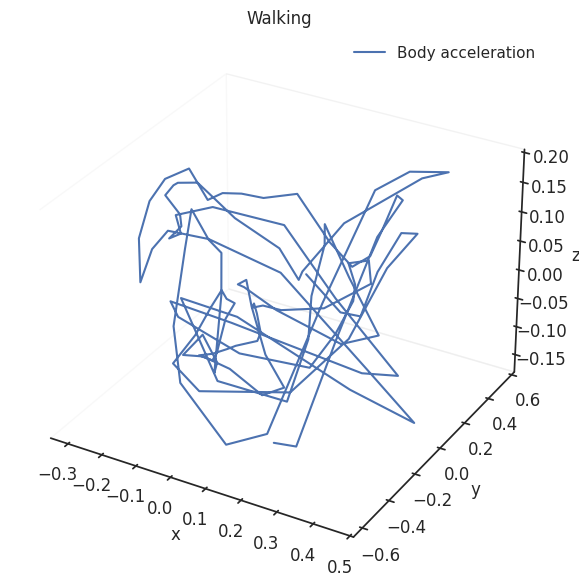

Sample 666


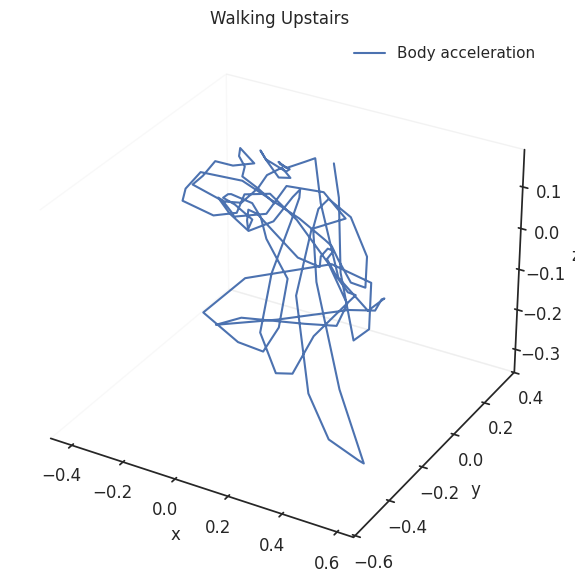

Sample 818


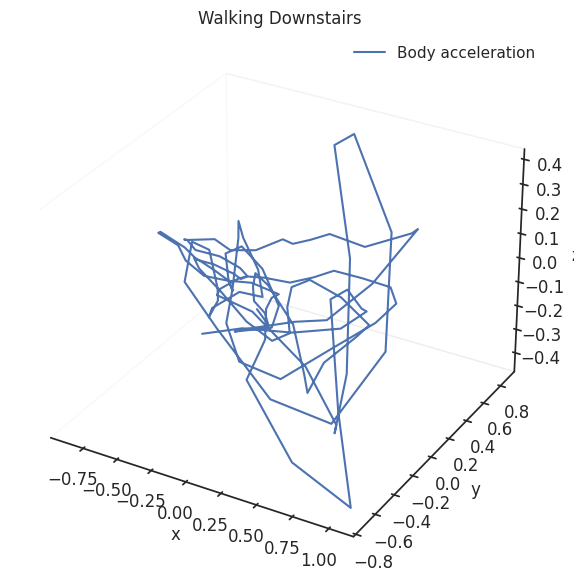

Sample 0


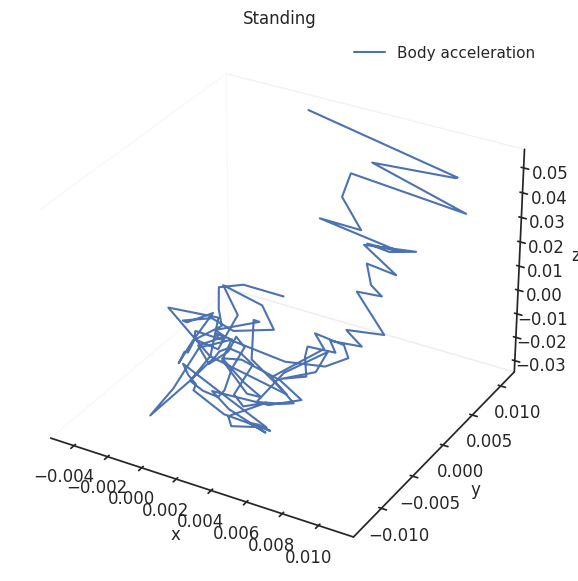

Sample 6666


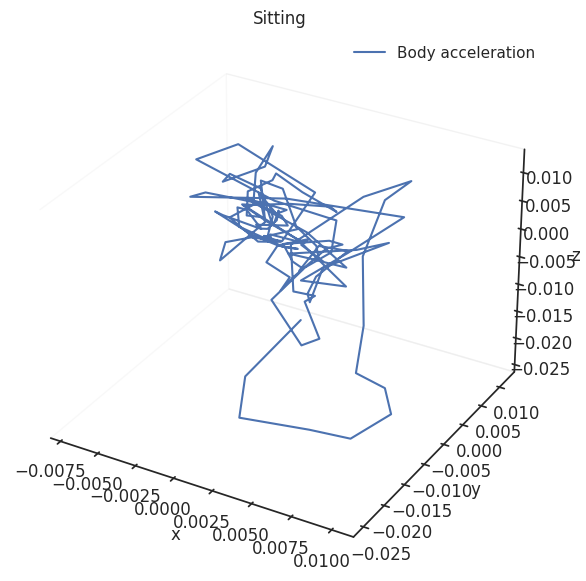

Sample 66


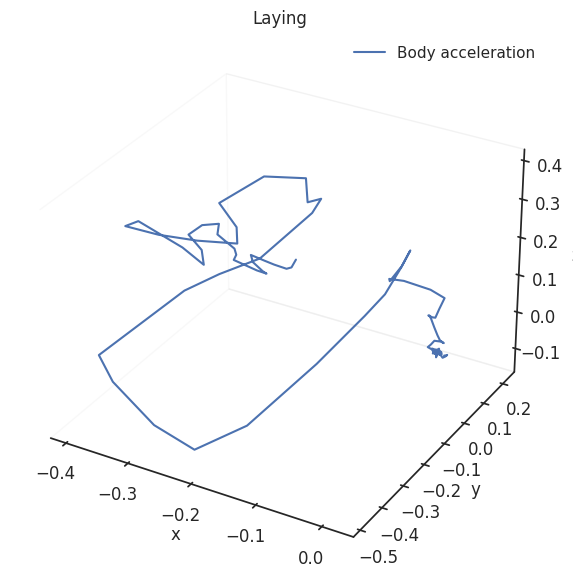

In [95]:
for i in sample:
    print("Sample", i)
    signal_3dviz(i, "Body acceleration")

Still very hard to make sense out of and to do any visual comparisons between the activities.
Will try to compute the distance of each timesteps to the origin (xyz = (0,0,0))

### Distance to Origin the Body Acceleration Feature

In [96]:
# Calculate the distance of each timesteps to origin (0,0,0)
def distance_viz(obs, feature):
    graph_name="graph/distance {} {}.png"
    activity_name = activities(obs)

    i=features(feature)

    sns.set(style="white", font_scale = 1)
    fig = plt.figure(figsize=(7,5))
    x = X_train[obs][:, i*3+0]
    y = X_train[obs][:, i*3+1]
    z = X_train[obs][:, i*3+2]
    plt.plot((x**2+y**2+z**2)**0.5, label=feature)
    plt.legend()
    plt.title(activity_name)
    plt.xlabel("Timesteps")
    plt.ylabel("Distance")
    plt.show()

Sample 777


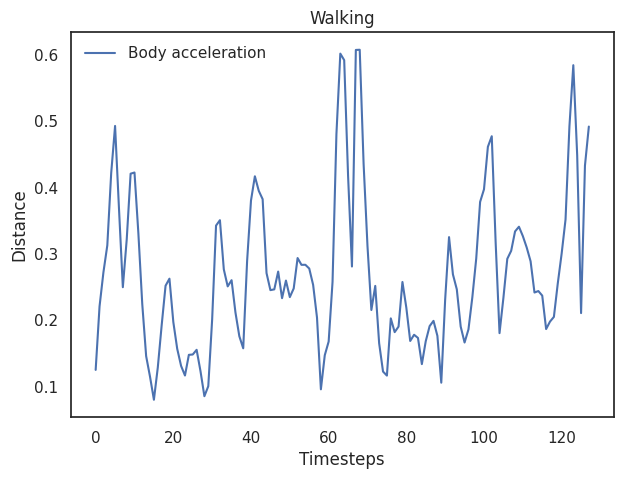

Sample 666


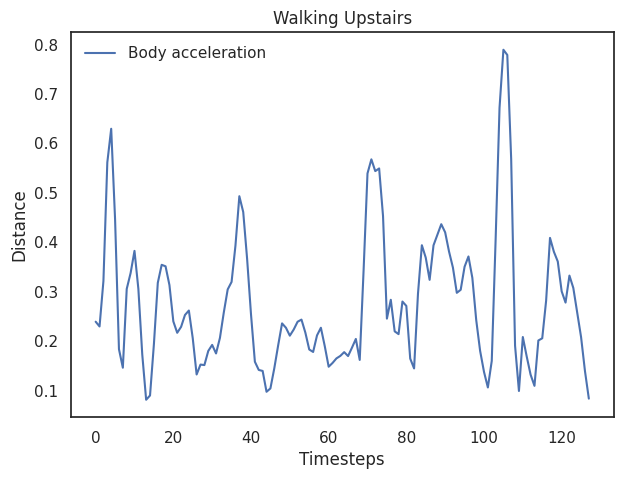

Sample 818


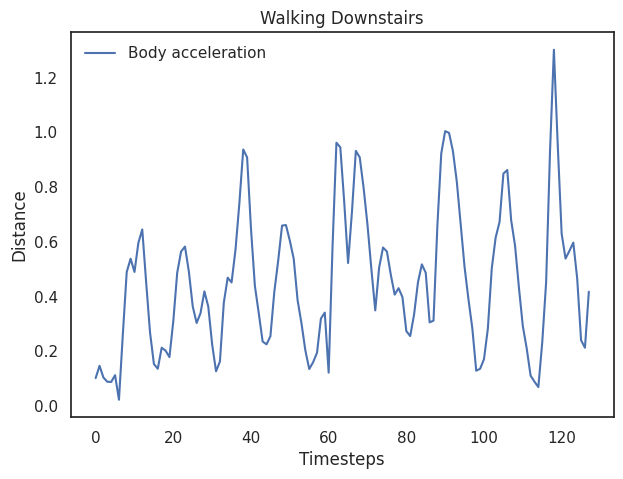

Sample 0


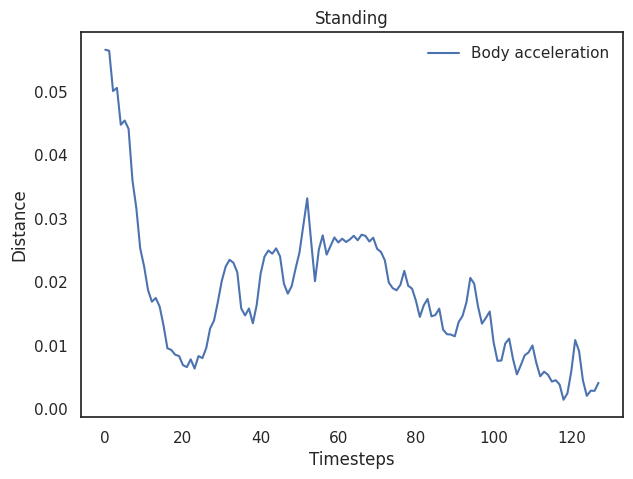

Sample 6666


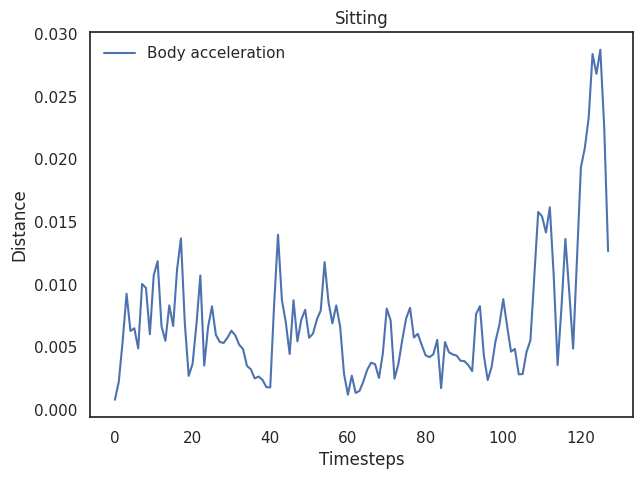

Sample 66


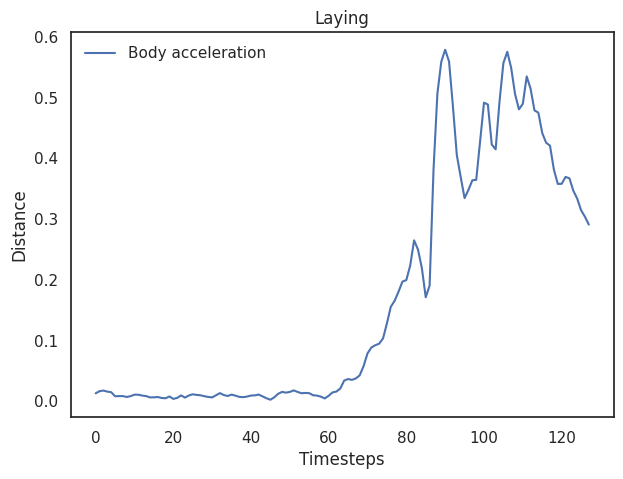

In [97]:
for i in sample:
    print("Sample", i)
    distance_viz(i, "Body acceleration")

It is now easier for us human eyes to compare the feature signals between different activities.

### EDA - Observations by Activity

In [98]:
def y_graph():
    y=pd.DataFrame(np.concatenate((y_train, y_test)), columns=["Activity"])
    y["Activity"]=y.Activity.map(activity)
    sns.set(style="white", font_scale=3)
    f, ax = plt.subplots(figsize=(40,15))
    sns.countplot(data=y, y="Activity")
    plt.title("Observations by Activity")
    plt.show()

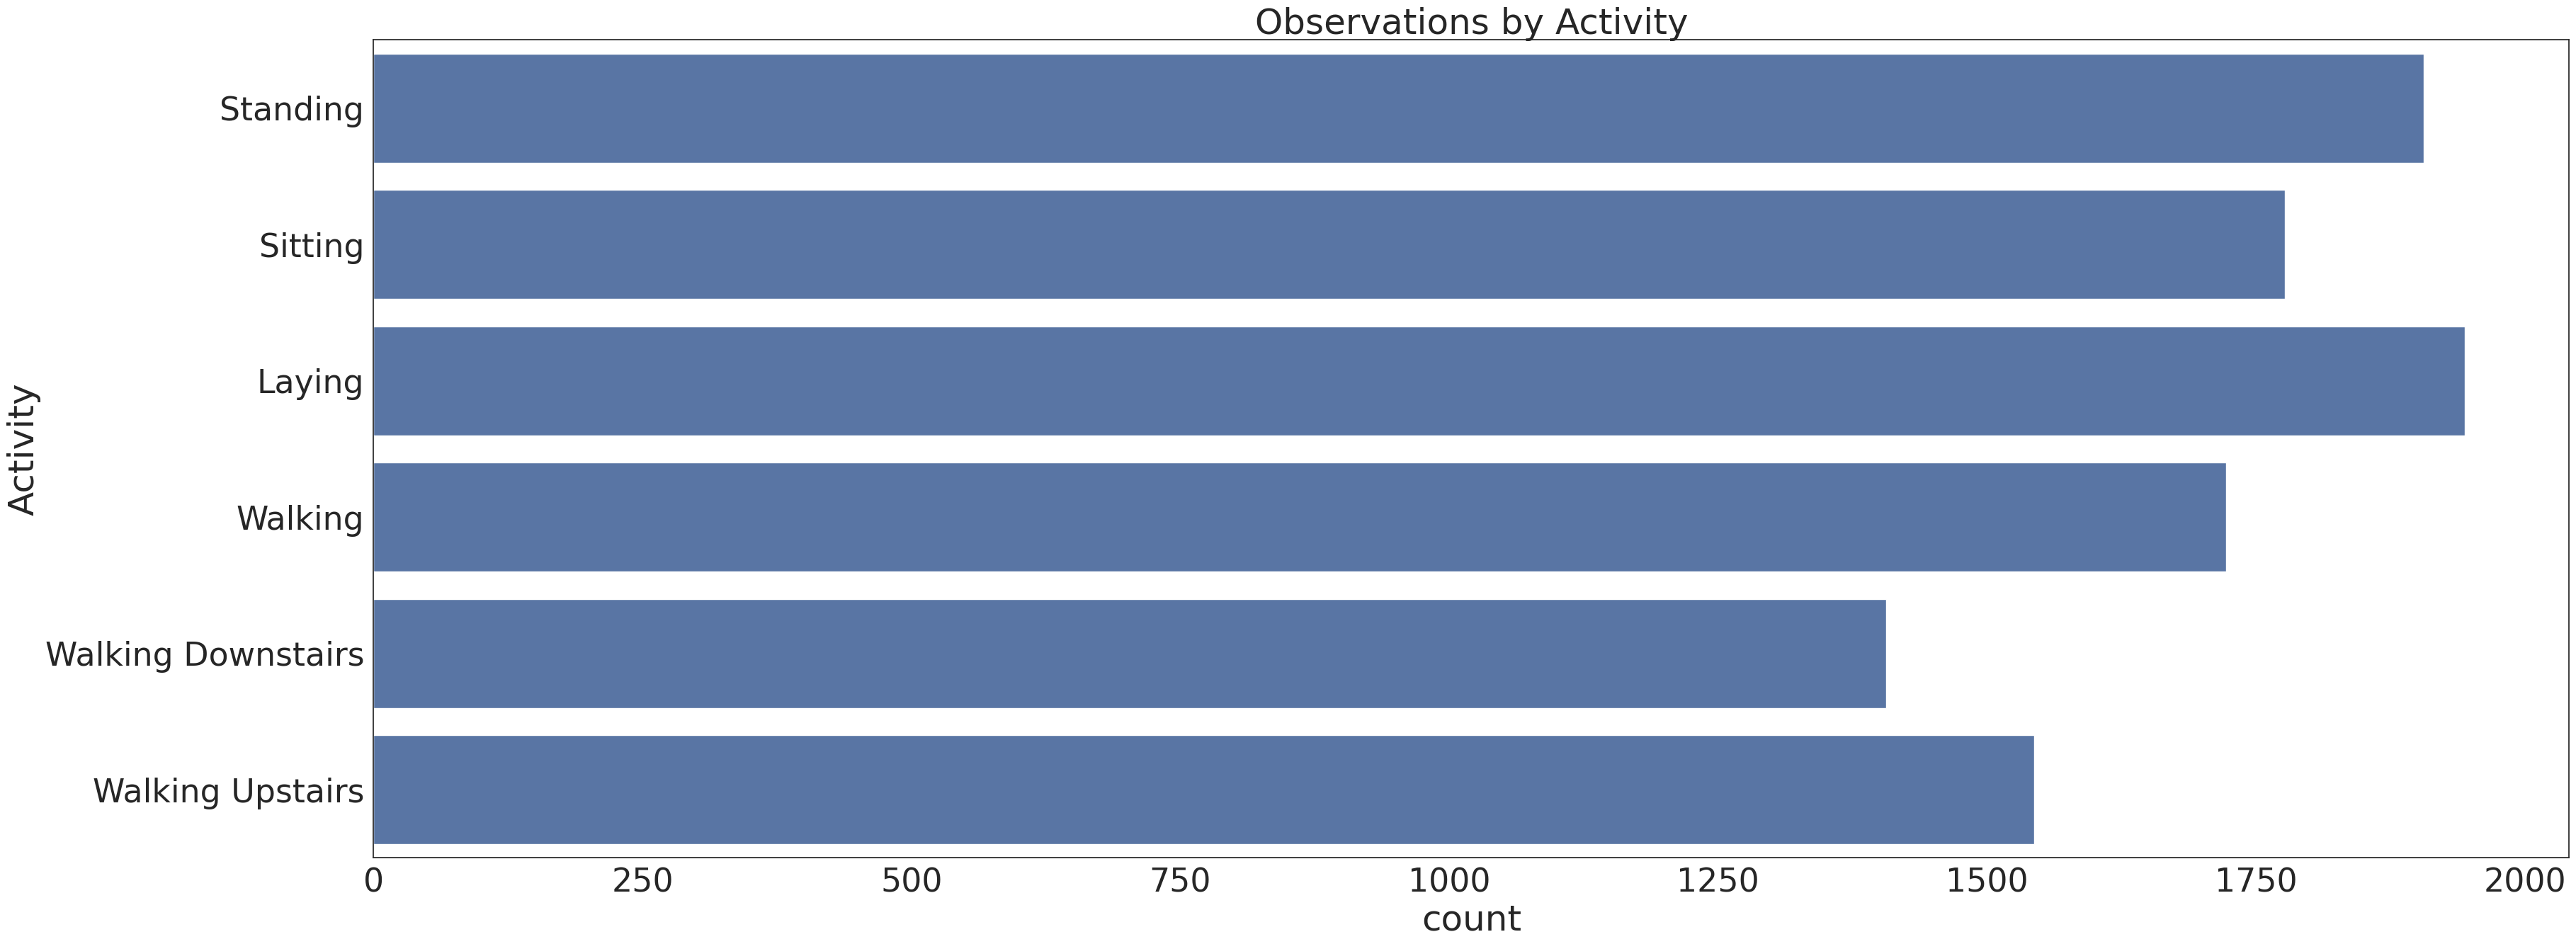

In [99]:
y_graph()

## Домашнее задание

1. Попробуйте вывасти распределение по классам для тестовой и тренировочной выборки
2. Придумайте самостоятельно визуализацию каких-либо закономерностей в предложенных данных

Список классов:

In [100]:
features_name = pd.read_csv(os.path.join(datadir, 'features.txt'), delim_whitespace=True, header=None, names=['column_index', 'column_name'])
features_name.head()

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


В списке классов есть повторяющиеся имена:

In [101]:
duplicates = features_name.groupby('column_name').count()
duplicates[duplicates['column_index'] > 1].head()

,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


Делаем уникальными, имена классов, и считываем тренировочную и обучающие выборки:

In [102]:
import os

features = list()

with open(os.path.join(datadir, 'features.txt')) as f:
    features = [line.split()[1] for line in f.readlines()]

In [103]:
seen = set()
uniq_features = []
for idx, x in enumerate(features):
    if x not in seen:
        uniq_features.append(x)
        seen.add(x)
    elif x + 'n' not in seen:
        uniq_features.append(x + 'n')
        seen.add(x + 'n')
    else:
        uniq_features.append(x + 'nn')
        seen.add(x + 'nn')

In [104]:
x_train = pd.read_csv(os.path.join(datadir, 'train/X_train.txt'), delim_whitespace=True, header=None, names=uniq_features)
y_train = pd.read_csv(os.path.join(datadir, 'train/y_train.txt'), names=['Activity'])
y_train = y_train.Activity.map(activity)
x_train['Activity'] = y_train
x_train['subject'] = pd.read_csv(os.path.join(datadir, 'train/subject_train.txt'), header=None)

x_test = pd.read_csv(os.path.join(datadir, 'test/X_test.txt'), delim_whitespace=True, header=None, names=uniq_features)
y_test = pd.read_csv(os.path.join(datadir, 'test/y_test.txt'), names=['Activity'])
y_test = y_test.Activity.map(activity)
x_test['Activity'] = y_test
x_test['subject'] = pd.read_csv(os.path.join(datadir, 'test/subject_test.txt'), header=None)

Статистика по тренировочной и обучающей выборкам:

In [105]:
x_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000


In [106]:
x_test.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,...,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000
mean,0.273996,-0.017863,-0.108386,-0.613635,-0.508330,-0.633797,-0.641278,-0.522676,-0.637038,-0.462063,...,-0.277593,-0.598756,0.005264,0.003799,0.040029,-0.017298,-0.513923,0.074886,-0.048720,12.986427
std,0.060570,0.025745,0.042747,0.412597,0.494269,0.362699,0.385199,0.479899,0.357753,0.523916,...,0.317245,0.311042,0.336147,0.445077,0.634989,0.501311,0.509205,0.324300,0.241467,6.950984
min,-0.592004,-0.362884,-0.576184,-0.999606,-1.000000,-0.998955,-0.999417,-0.999914,-0.998899,-0.952357,...,-1.000000,-1.000000,-1.000000,-0.993402,-0.998898,-0.991096,-0.984195,-0.913704,-0.949228,2.000000
25%,0.262075,-0.024961,-0.121162,-0.990914,-0.973664,-0.976122,-0.992333,-0.974131,-0.975352,-0.934447,...,-0.517494,-0.829593,-0.130541,-0.282600,-0.518924,-0.428375,-0.829722,0.022140,-0.098485,9.000000
50%,0.277113,-0.016967,-0.108458,-0.931214,-0.790972,-0.827534,-0.937664,-0.799907,-0.817005,-0.852659,...,-0.311023,-0.683672,0.005188,0.006767,0.047113,-0.026726,-0.729648,0.181563,-0.010671,12.000000
75%,0.288097,-0.010143,-0.097123,-0.267395,-0.105919,-0.311432,-0.321719,-0.133488,-0.322771,-0.009965,...,-0.083559,-0.458332,0.146200,0.288113,0.622151,0.394387,-0.545939,0.260252,0.092373,18.000000
max,0.671887,0.246106,0.494114,0.465299,1.000000,0.489703,0.439657,1.000000,0.427958,0.786436,...,1.000000,1.000000,0.998898,0.986347,1.000000,1.000000,0.833180,1.000000,0.973113,24.000000


Распределение по классам для тестовой и тренировочной выборкам

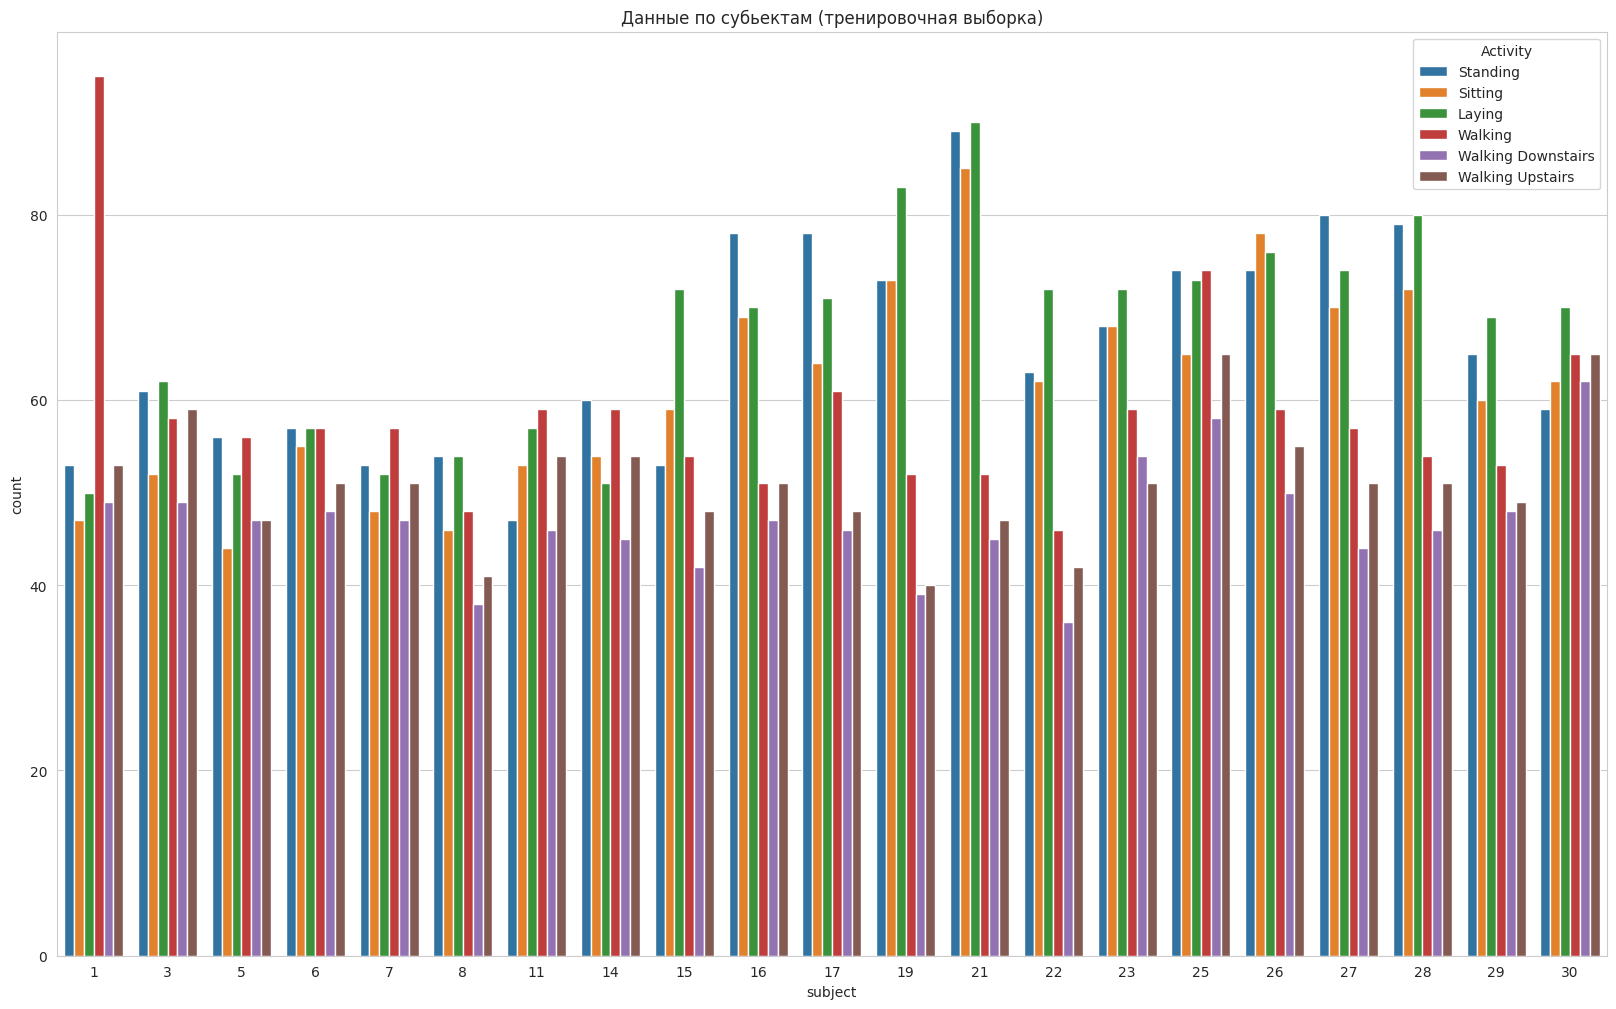

In [170]:
sns.reset_defaults()
sns.set_style('whitegrid')
plt.figure(figsize=(20,12))
plt.title('Данные по субьектам (тренировочная выборка)')
sns.countplot(x='subject', data = x_train, hue='Activity')
plt.show()

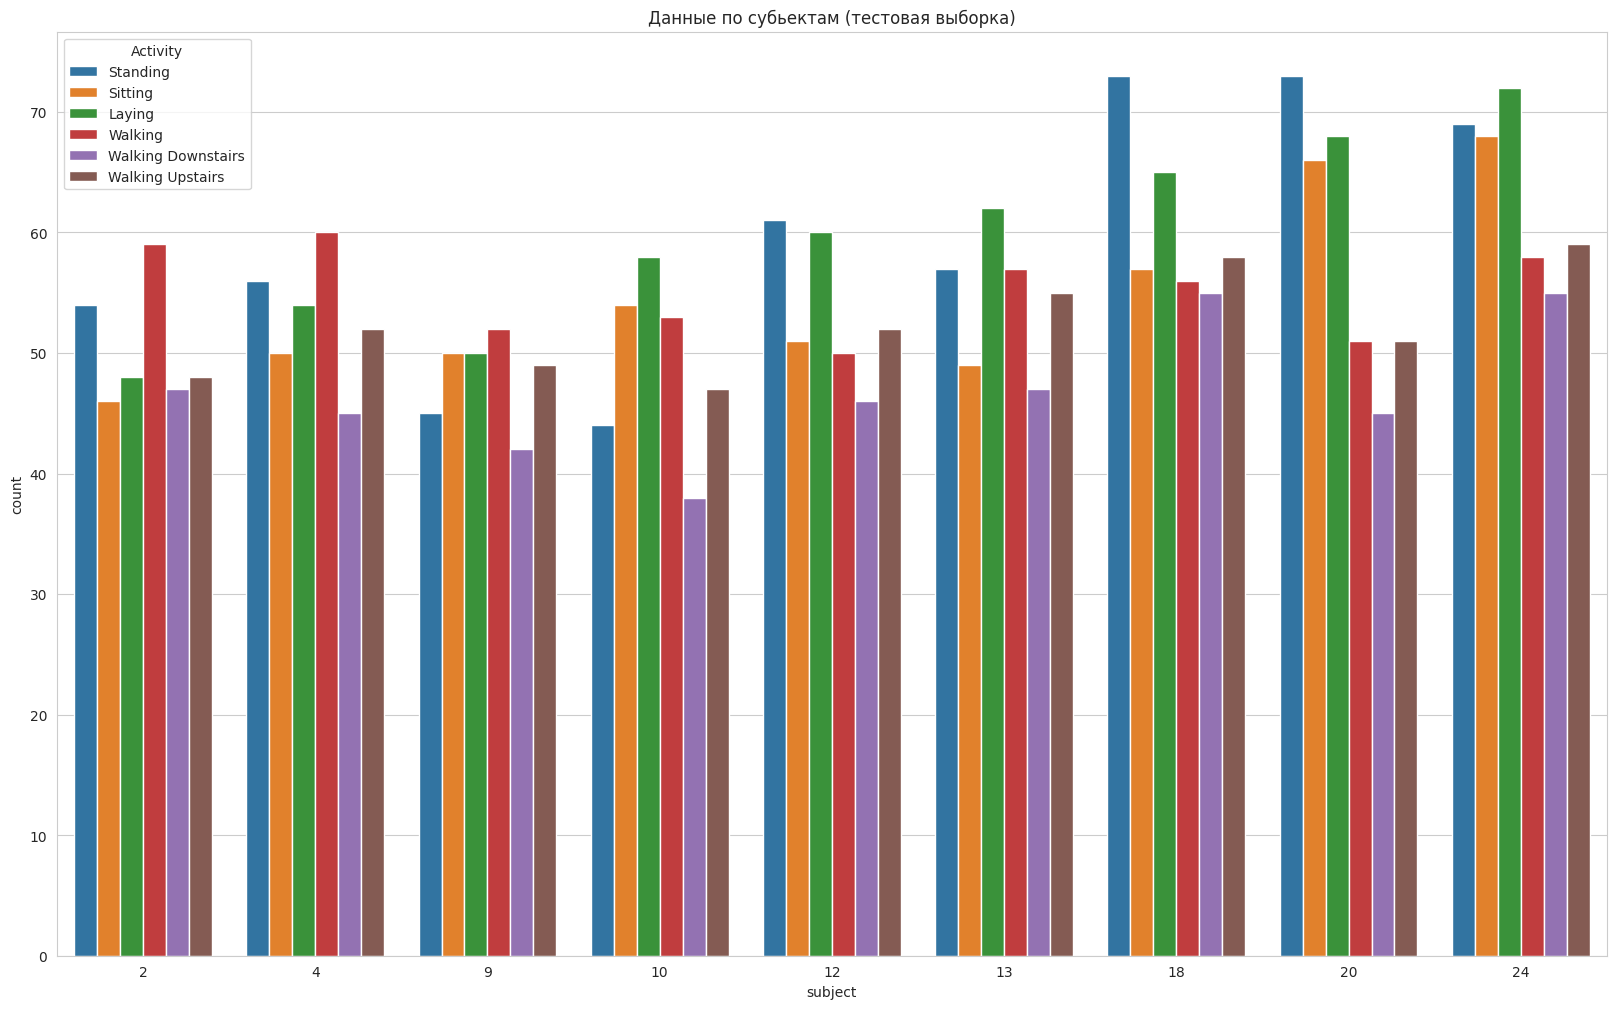

In [172]:
sns.reset_defaults()
sns.set_style('whitegrid')
plt.figure(figsize=(20,12))
plt.title('Данные по субьектам (тестовая выборка)')
sns.countplot(x='subject', data = x_test, hue='Activity')
plt.show()

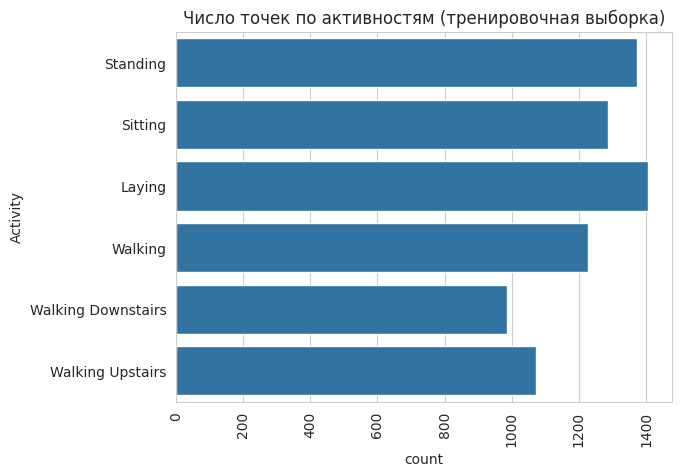

In [175]:
plt.title('Число точек по активностям (тренировочная выборка)')
sns.countplot(x_train.Activity)
plt.xticks(rotation=90)
plt.show()

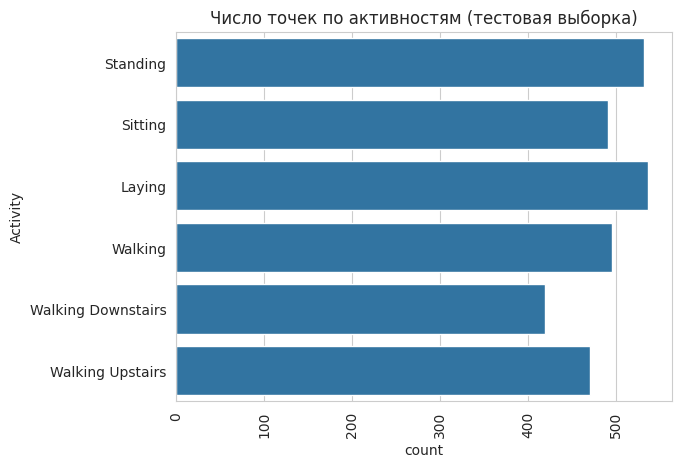

In [176]:
plt.title('Число точек по активностям (тестовая выборка)')
sns.countplot(x_test.Activity)
plt.xticks(rotation=90)
plt.show()

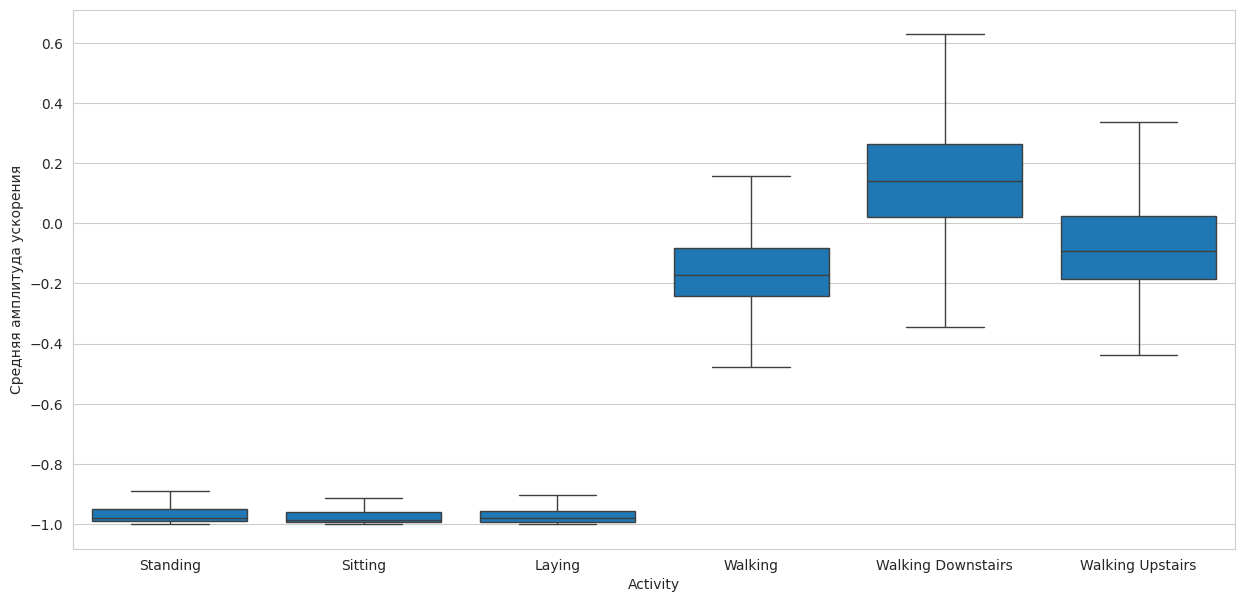

In [201]:
plt.figure(figsize=(15,7))
sns.boxplot(x='Activity', y='tBodyAccMag-mean()', data=x_train, showfliers=False, saturation=1)
plt.ylabel('Средняя амплитуда ускорения')
plt.show()

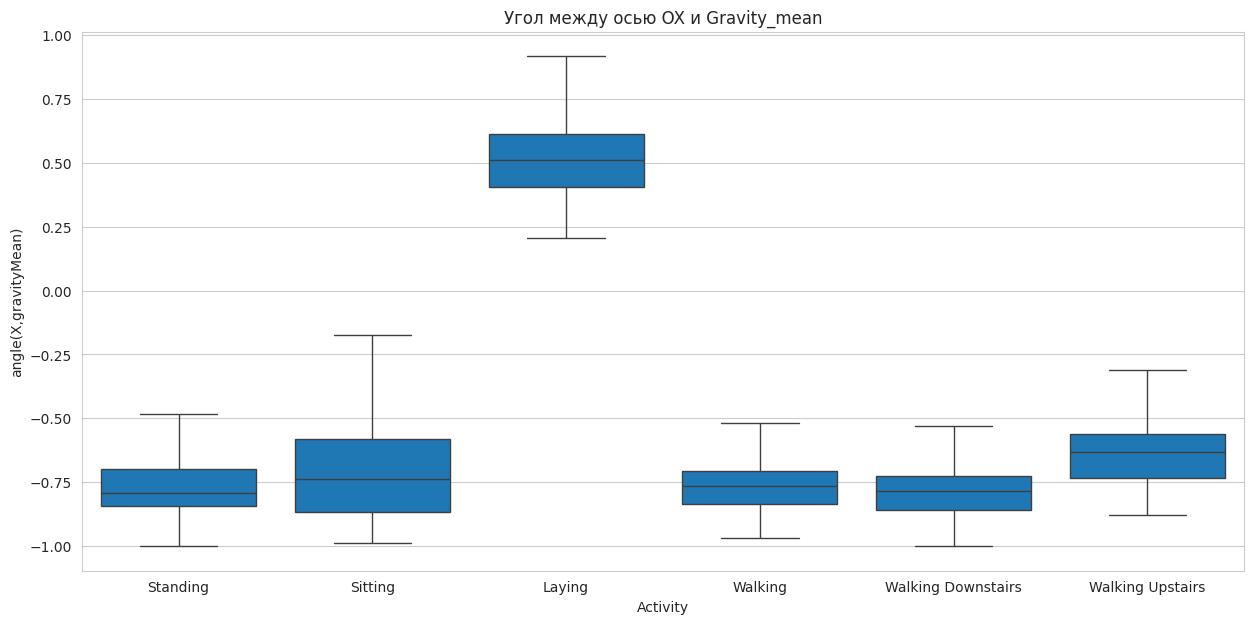

In [208]:
plt.figure(figsize=(15,7))
sns.boxplot(x='Activity', y='angle(X,gravityMean)', data=x_train, showfliers=False, saturation=1)
plt.title('Угол между осью OX и Gravity_mean')
plt.show()

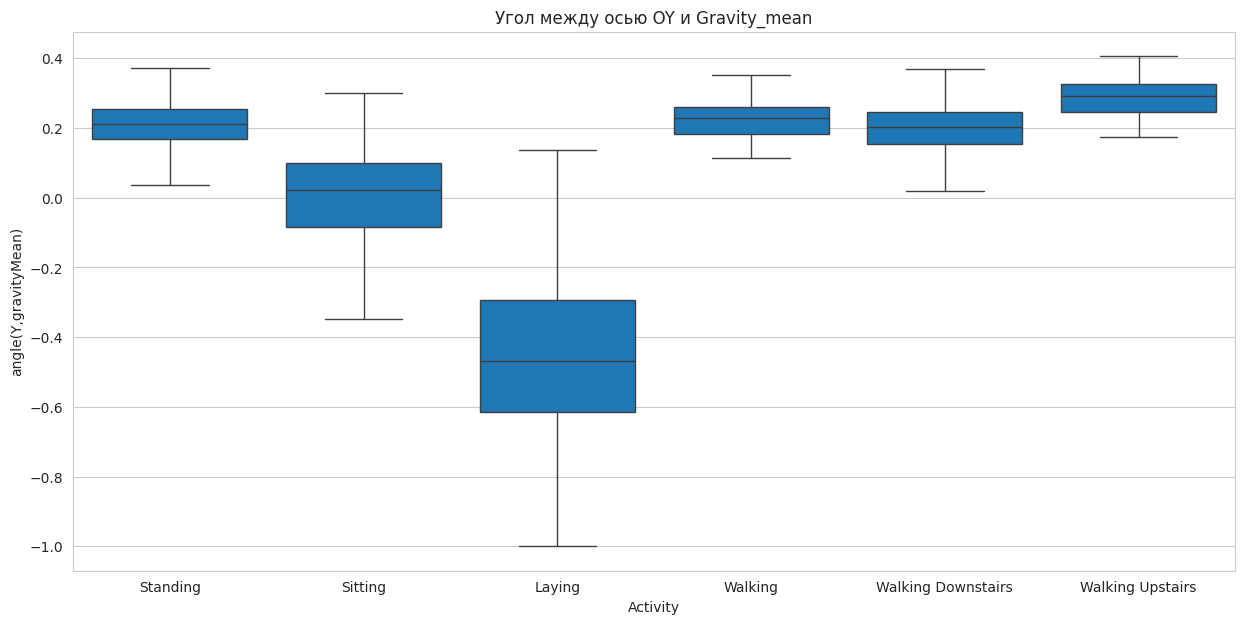

In [209]:
plt.figure(figsize=(15,7))
sns.boxplot(x='Activity', y='angle(Y,gravityMean)', data=x_train, showfliers=False, saturation=1)
plt.title('Угол между осью OY и Gravity_mean')
plt.show()

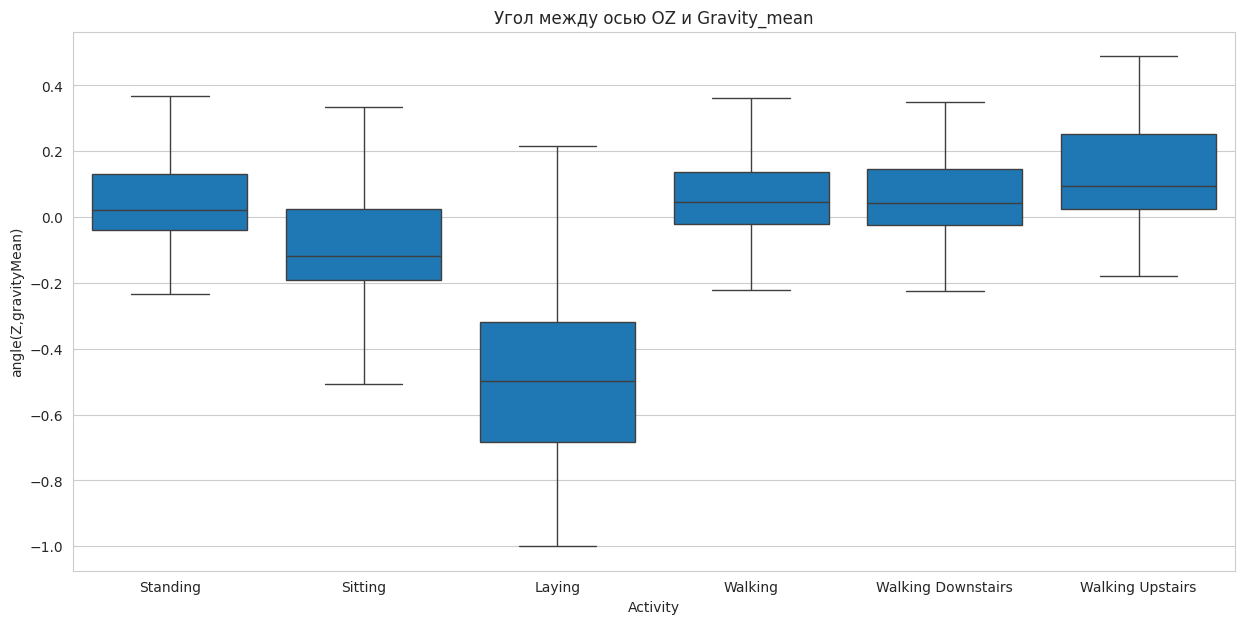

In [210]:
plt.figure(figsize=(15,7))
sns.boxplot(x='Activity', y='angle(Z,gravityMean)', data=x_train, showfliers=False, saturation=1)
plt.title('Угол между осью OZ и Gravity_mean')
plt.show()

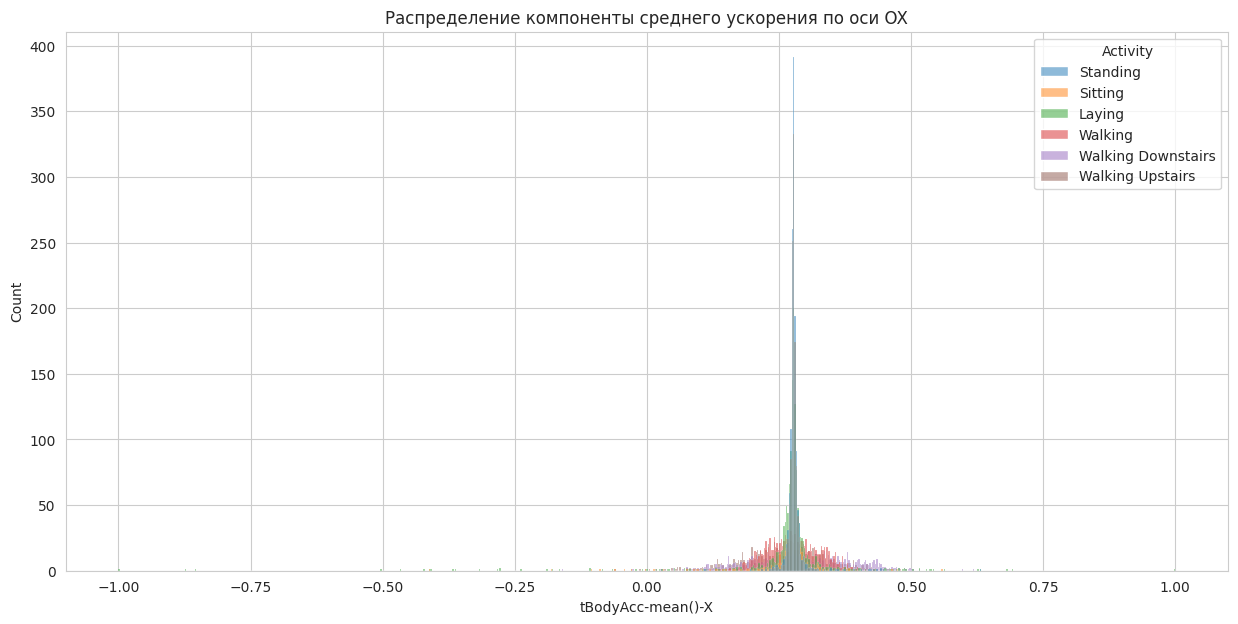

In [235]:
plt.figure(figsize=(15,7))
sns.histplot(data=x_train, x='tBodyAcc-mean()-X', hue='Activity');
plt.title('Распределение компоненты среднего ускорения по оси OX')
plt.show()

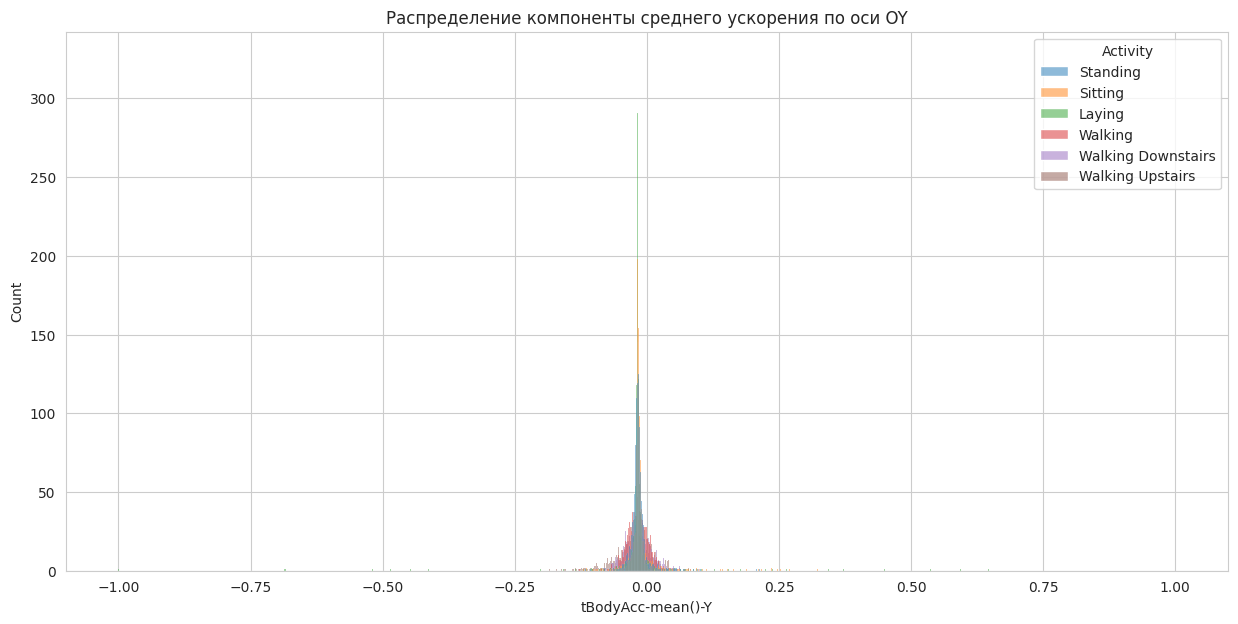

In [236]:
plt.figure(figsize=(15,7))
sns.histplot(data=x_train, x='tBodyAcc-mean()-Y', hue='Activity');
plt.title('Распределение компоненты среднего ускорения по оси OY')
plt.show()

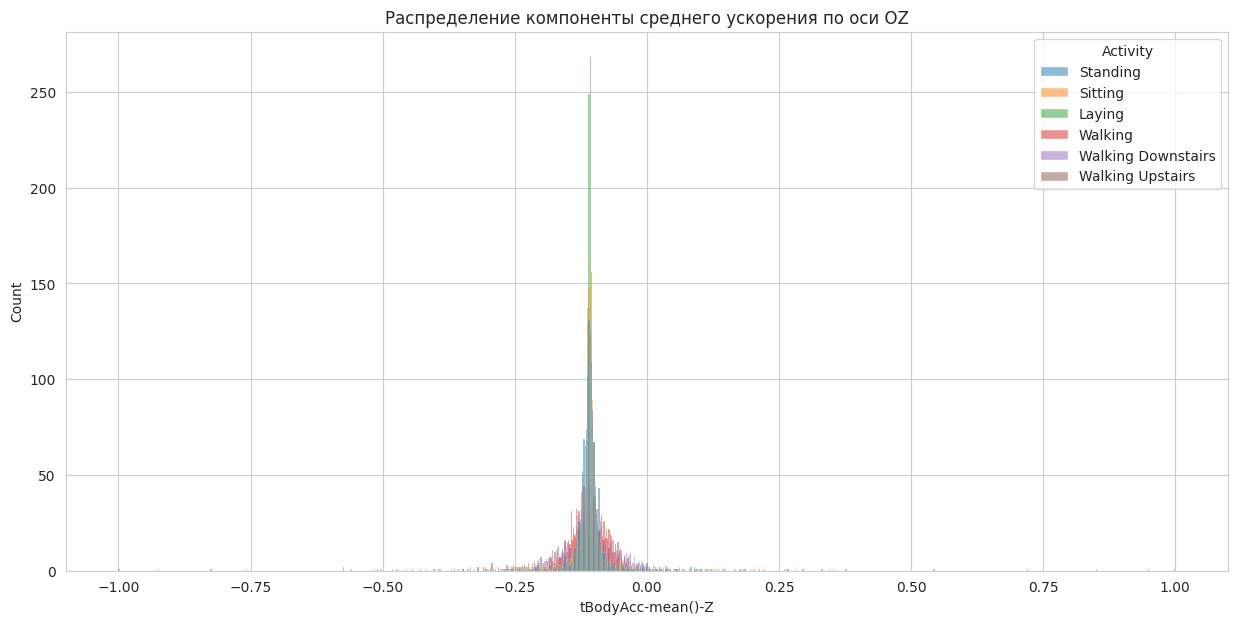

In [237]:
plt.figure(figsize=(15,7))
sns.histplot(data=x_train, x='tBodyAcc-mean()-Z', hue='Activity');
plt.title('Распределение компоненты среднего ускорения по оси OZ')
plt.show()